In [1]:
!pip install cmake opencv-python
!conda install -y dlib

Channels:
 - conda-forge
Platform: linux-64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 25.5.1
    latest version: 25.11.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.



In [2]:
import cv2
import dlib

print(cv2.__version__)
print(dlib.__version__)

4.12.0
20.0.0


In [3]:
# Step 2. 얼굴 검출 & 랜드마크 검출 하기

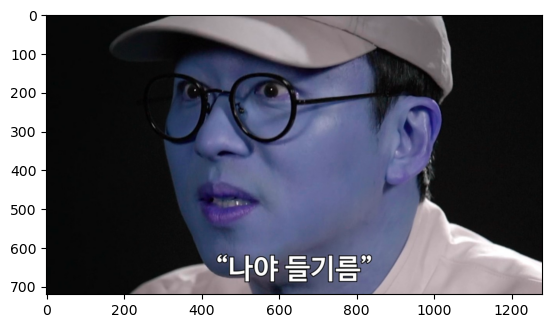

In [22]:
# 필요한 패키지 import 하기
import os 
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

home_dir = os.getenv('HOME')
my_image_path = os.path.join(home_dir, 'work/camera_sticker/images/choi_2.jpg')
img_bgr = cv2.imread(my_image_path)
img_show = img_bgr.copy()
plt.imshow(img_bgr)
plt.show()

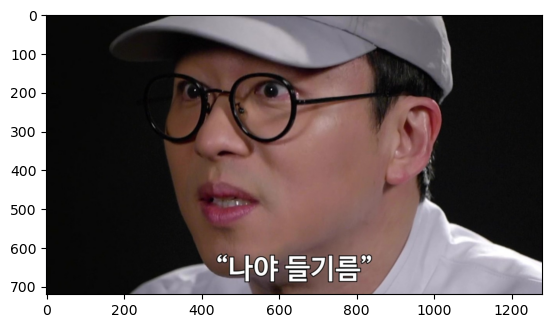

In [23]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [24]:
detector_hog = dlib.get_frontal_face_detector()

In [25]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)
print("🌫🛸")

🌫🛸


rectangles[[(132, -89) (798, 650)]]


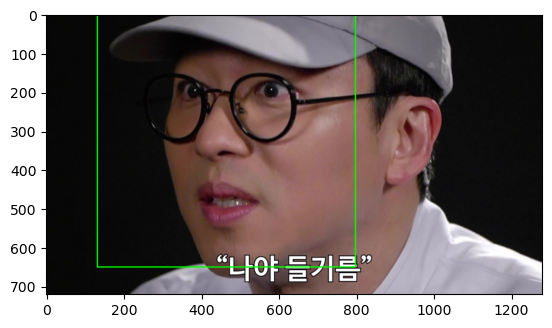

In [26]:
print(dlib_rects)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    d = dlib_rect.bottom()

    cv2.rectangle(img_show, (l, t), (r, d), (0, 255, 0), 2, lineType=cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [9]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!mv shape_predictor_68_face_landmarks.dat.bz2 ~/work/camera_sticker/models


--2026-01-16 05:28:59--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 [following]
--2026-01-16 05:28:59--  https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Connecting to dlib.net (dlib.net)|107.180.26.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  17.0MB/s    in 3.9s    

2026-01-16 05:29:04 (15.5 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [27]:
model_path = os.path.join(home_dir, 'work/camera_sticker/models/shape_predictor_68_face_landmarks.dat')
landmark_predictor = dlib.shape_predictor(model_path)
print("🌫🛸")

🌫🛸


In [28]:
list_landmarks = []

for dlib_rect in dlib_rects:   #여기 왜 for문을? 검출된 모든 얼굴들의 bounding box 리스트이기 때문
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


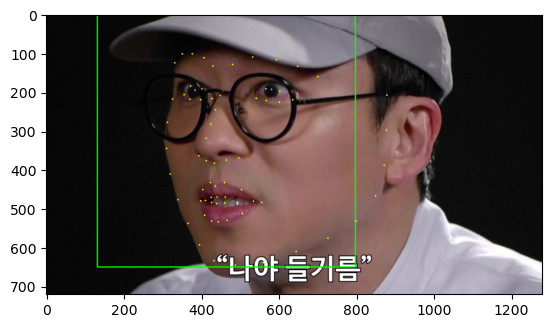

In [29]:
# 여러 개의 얼굴이 검출됐다는 가정하에 list_landmarks는 리스트 형태임
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [13]:
# Step 3. 스티커 적용 위치 확인하기

In [30]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(landmark[33]) # 코의 인덱스는 30
    x = landmark[33][0]
    y = landmark[33][1] + dlib_rect.height() // 2
    w = h = dlib_rect.width()

    print(f"(x,y) : ({x}, {y})")
    print(f"(w,h) : ({w}, {h})")

(434, 383)
(x,y) : (434, 753)
(w,h) : (667, 667)


In [15]:
# Step 4. 스티커 적용하기

In [31]:
sticker_path = os.path.join(home_dir, 'work/camera_sticker/images/cat-whiskers.png')
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w, h))
print(img_sticker.shape)

(667, 667, 3)


In [32]:
refined_x = x - w // 2
refined_y = y - h

print(f'(x, y) : ({refined_x}, {refined_y})')


(x, y) : (101, 86)


In [36]:
# 이미지가 밖으로 시작하는 경우 예외처리
if refined_x < 0:
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0

if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print(f"(x, y) : ({refined_x}, {refined_y})")

(x, y) : (101, 86)


In [41]:
# 오른쪽, 아래쪽으로 이미지가 넘어가는 경우 예외처리

H, W = img_show.shape[:2]
sh, sw = img_sticker.shape[:2]

# 스티커가 놓일 끝 좌표
end_x = refined_x + sw
end_y = refined_y + sh

# 오른쪽/아래쪽이 넘어가면 스티커를 잘라낸다
if end_x > W:
    img_sticker = img_sticker[:, :W - refined_x]
if end_y > H:
    img_sticker = img_sticker[:H - refined_y, :]


In [42]:
sticker_area = img_show[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

img_show[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x + img_sticker.shape[1]] = np.where(img_sticker==255, sticker_area, img_sticker).astype(np.uint8)

print("슝슝")

슝슝


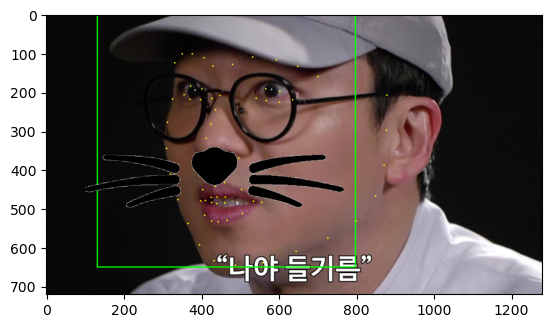

In [39]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

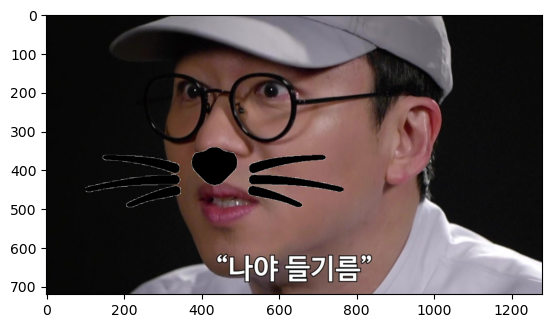

In [40]:
sticker_area = img_bgr[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
np.where(img_sticker==255, sticker_area, img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()